In [1]:
# Exploratory Data Analysis
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Base path from notebook to data folder
BASE = '../src/data/'

In [5]:
# Load tables
products = pd.read_csv(BASE + 'products.csv')
edges    = pd.read_csv(BASE + 'edges.csv')
reviews  = pd.read_csv(BASE + 'reviews.csv', parse_dates=['date'])

In [6]:
# Quick look
display(products.head())
display(edges.head())
display(reviews.head())

,Id,ASIN,title,salesrank,group,average_rating,num_reviews
0,0,0771044445,NaN,300490,NaN,NaN,NaN
1,1,0827229534,Patterns of Preaching: A Sermon Sampler,396585,Book,5.0,2.0
2,2,0738700797,Candlemas: Feast of Flames,168596,Book,4.5,12.0
3,3,0486287785,World War II Allied Fighter Planes Trading Cards,1270652,Book,5.0,1.0
4,4,0842328327,Life Application Bible Commentary: 1 and 2 Tim...,631289,Book,4.0,1.0


,source,target
0,0827229534,0804215715
1,0827229534,156101074X
2,0827229534,0687023955
3,0827229534,0687074231
4,0827229534,082721619X


,ASIN,date,rating
0,0827229534,2000-07-28,5
1,0827229534,2003-12-14,5
2,0738700797,2001-12-16,5
3,0738700797,2002-01-07,4
4,0738700797,2002-01-24,5


In [7]:
# Products: check for NaNs
print(products.isna().sum())
print('Review date nulls:', reviews['date'].isna().sum())

Id                   0
ASIN                 0
title             5868
salesrank            0
group             5868
average_rating    5868
num_reviews       5868
dtype: int64
Review date nulls: 0


In [8]:
# Drop products missing titles (and thus group)
before = len(products)
products = products.dropna(subset=['title'])
after = len(products)
print(f"Dropped {before - after} products without titles → {after} remaining")

Dropped 5868 products without titles → 542684 remaining


In [9]:
# Fill any missing group labels
products['group'] = products['group'].fillna('Unknown')

In [10]:
# Drop reviews with invalid dates
before_r = len(reviews)
reviews = reviews.dropna(subset=['date'])
after_r = len(reviews)
print(f"Dropped {before_r - after_r} reviews with bad dates → {after_r} remaining")

Dropped 0 reviews with bad dates → 7593109 remaining


In [11]:
# Verify no more NaNs
print(products.isna().sum())
print('Review date nulls:', reviews['date'].isna().sum())

Id                0
ASIN              0
title             0
salesrank         0
group             0
average_rating    0
num_reviews       0
dtype: int64
Review date nulls: 0


In [12]:
# Reviews: check for NaNs in date or rating
print("Reviews null counts:")
print(reviews.isna().sum())

Reviews null counts:
ASIN      0
date      0
rating    0
dtype: int64


In [13]:
# Edges: check for NaNs in source or target
print("\nEdges null counts:")
print(edges.isna().sum())


Edges null counts:
source    0
target    0
dtype: int64


In [14]:
valid_asins = set(products['ASIN'])
before = len(edges)
edges = edges[
    edges['source'].isin(valid_asins) &
    edges['target'].isin(valid_asins)
]
after = len(edges)
print(f"Dropped {before - after} edges to discontinued/nonexistent ASINs → {after} remaining")

Dropped 557325 edges to discontinued/nonexistent ASINs → 1231400 remaining


In [28]:
# Drop any malformed edges
before = len(edges)
edges = edges.dropna(subset=['source', 'target'])
after = len(edges)
print(f"Dropped {before - after} malformed edges → {after} remaining")

Dropped 0 malformed edges → 1231400 remaining


C:\Users\karti\AppData\Local\Temp\ipykernel_22100\836050620.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=reviews, x='rating', palette='viridis')


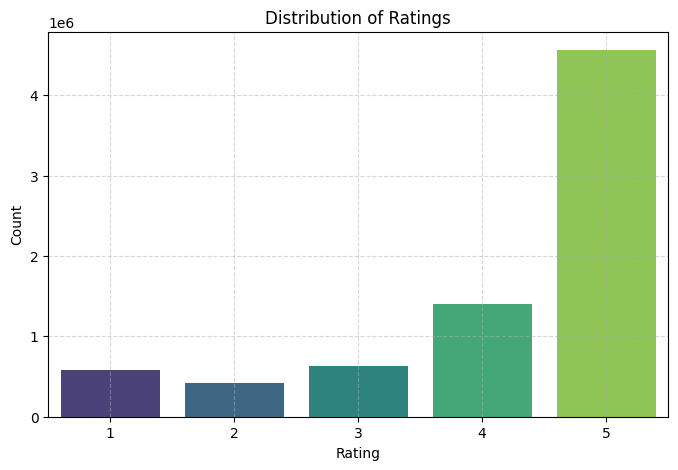

In [16]:
# Distribution of ratings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load reviews data
# reviews_df = pd.read_csv('reviews.csv')

# Plot distribution of ratings
plt.figure(figsize=(8, 5))
sns.countplot(data=reviews, x='rating', palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [21]:
import pandas as pd

# Load product data
products_df = products.copy()  # Use a copy to avoid modifying original

# Convert 'salesrank' to numeric, coercing errors to NaN
products_df['salesrank'] = pd.to_numeric(products_df['salesrank'], errors='coerce')

# Drop rows with missing or invalid (<= 0) salesrank values
products_df = products_df[products_df['salesrank'] > 0]

# Sort products by salesrank (ascending: lower = more bought)
most_bought = products_df.sort_values(by='salesrank').reset_index(drop=True)

# Display top 5 most bought products
print("Top 5 Most Bought Products:")
print(most_bought[['ASIN', 'title', 'salesrank']].head(5).to_string(index=False))


Top 5 Most Bought Products:
      ASIN                                                     title  salesrank
6300215539                                     The War of the Worlds          1
6301627024                                         Shirley Valentine          2
B00005T33H Leslie Sansone - Walk Away the Pounds - Super Fat Burning          6
6302946387                                Robin Hood - Men in Tights          7
6301729897                  Richard Simmons - Sweatin' to the Oldies          8


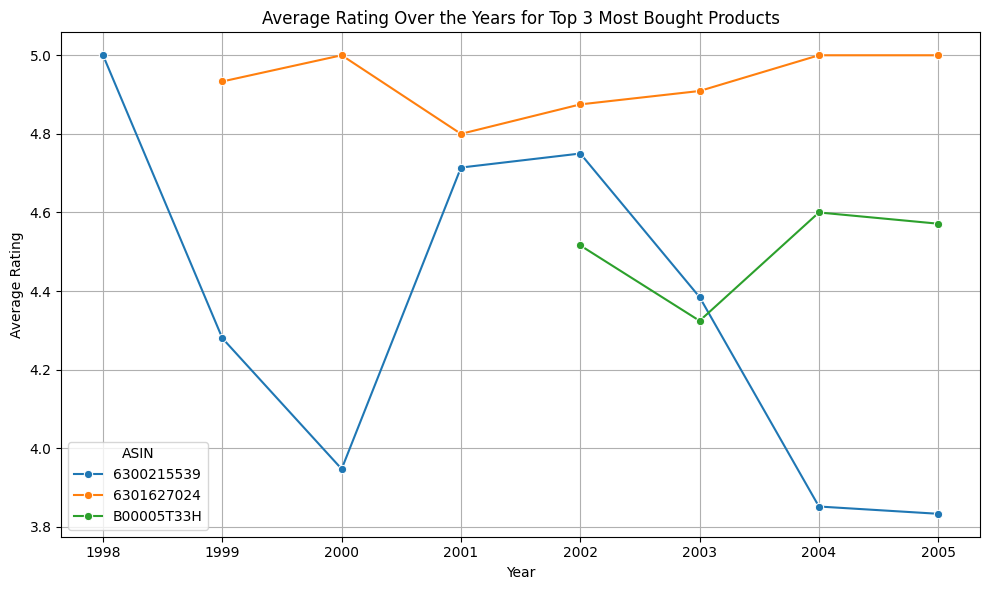

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'date' is in datetime format
reviews['date'] = pd.to_datetime(reviews['date'])

# Extract year from the date
reviews['year'] = reviews['date'].dt.year

# Pick top 3 most bought products
top_asins = most_bought['ASIN'].head(3).tolist()

# Filter reviews for those ASINs
top_reviews = reviews[reviews['ASIN'].isin(top_asins)]

# Group by ASIN and year to get average rating
avg_ratings = top_reviews.groupby(['ASIN', 'year'])['rating'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_ratings, x='year', y='rating', hue='ASIN', marker='o')

plt.title('Average Rating Over the Years for Top 3 Most Bought Products')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.xticks(avg_ratings['year'].unique())  # Make sure all years are shown
plt.legend(title='ASIN')
plt.grid(True)
plt.tight_layout()
plt.show()
